# Example notebook

In [1]:
import numpy as np
from anndata import AnnData
import pandas as pd
import scdebussy
import matplotlib.pyplot as plt

In [ ]:
def make_demo_adata(seed=7):
    """
    Simulates 5 samples with different temporal patterns in gene expression.

    - gene_up: a sigmoid function that increases from 0 to 1 as the canonical time increases
    - gene_down: a sigmoid function that decreases from 1 to 0 as the canonical time increases
    - gene_peak: a Gaussian function that peaks at a specific canonical time
    - gene_double: a combination of two Gaussian functions that peak at different canonical times
    """
    rng = np.random.default_rng(seed)

    # ----- gene programs on canonical time u in [0,1]
    f = {
        "gene_up": lambda u: 1 / (1 + np.exp(-8 * (u - 0.5))),
        "gene_down": lambda u: 1 / (1 + np.exp(8 * (u - 0.5))),
        "gene_peak": lambda u: np.exp(-((u - 0.6) ** 2) / 0.02),
        "gene_double": lambda u: 0.7 * np.exp(-((u - 0.3) ** 2) / 0.01) + 0.6 * np.exp(-((u - 0.8) ** 2) / 0.015),
    }
    genes = list(f.keys())

    # ----- sample-specific monotone warps (nonlinear)
    warps = [
        lambda t: t,
        lambda t: np.where(t < 0.5, 0.7 * t, 0.35 + 0.6 * (t - 0.5)),  # slow→fast
        lambda t: np.clip(t + 0.08 * np.sin(2 * np.pi * t) + 0.1 * t * (1 - t), 0, 1),  # smooth S
        lambda t: t**0.7,  # late dilate
        lambda t: t**1.5,  # early dilate
    ]
    samples = [f"S{i + 1}" for i in range(len(warps))]
    n_per = [450, 500, 400, 520, 480]  # uneven cell counts
    betas = [(3, 6), (1, 1), (2, 5), (6, 3), (5, 2)]  # Beta densities
    crops = [(0.05, 0.95), (0, 0.9), (0.1, 1), (0, 1), (0.15, 1)]  # partial overlap

    X_list, obs_list = [], []
    for sid, warp, (a, b), n, (lo, hi) in zip(samples, warps, betas, n_per, crops, strict=False):
        t = np.sort(rng.beta(a, b, size=n))
        t = t[(t >= lo) & (t <= hi)]  # crop to simulate partial overlap
        u = warp(t)  # canonical time (ground truth)
        amp = rng.normal(1.0, 0.05, len(genes))  # per-sample gene amplitude
        base = rng.normal(0.0, 0.03, len(genes))  # per-sample baseline
        expr = np.vstack(
            [np.maximum(amp[j] * f[g](u) + base[j] + rng.normal(0, 0.03, len(t)), 0.0) for j, g in enumerate(genes)]
        ).T
        X_list.append(expr)
        obs_list.append(pd.DataFrame({"sample": sid, "pseudotime": t, "canonical_time": u}))

    X = np.vstack(X_list)
    obs = pd.concat(obs_list, ignore_index=True)
    var = pd.DataFrame({"gene": genes}).set_index("gene")
    return AnnData(X, obs=obs, var=var)


# Create the dataset for your demo notebook
adata = make_demo_adata()

/usersoftware/chanj3/tslearn/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [3]:
adata = scdebussy.tl.align_pseudotime(adata, pseudotime_key="pseudotime", batch_key="sample", gamma=1)

Interpolating expression data...


Processing batches: 100%|██████████| 5/5 [00:00<00:00, 830.52it/s]


Computing barycenter using soft-DTW...


Mapping pseudotime: 100%|██████████| 5/5 [00:00<00:00, 288.68it/s]

Pseudotime mapping completed.
Alignment and barycenter computation completed.


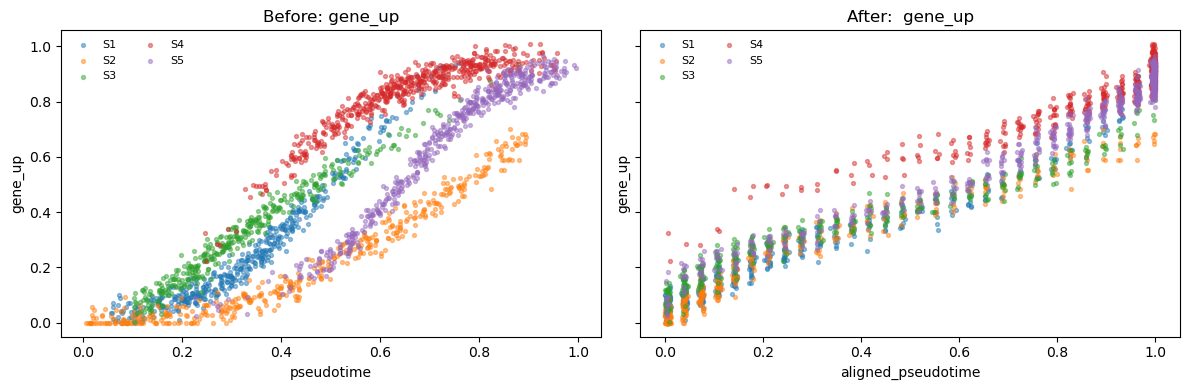

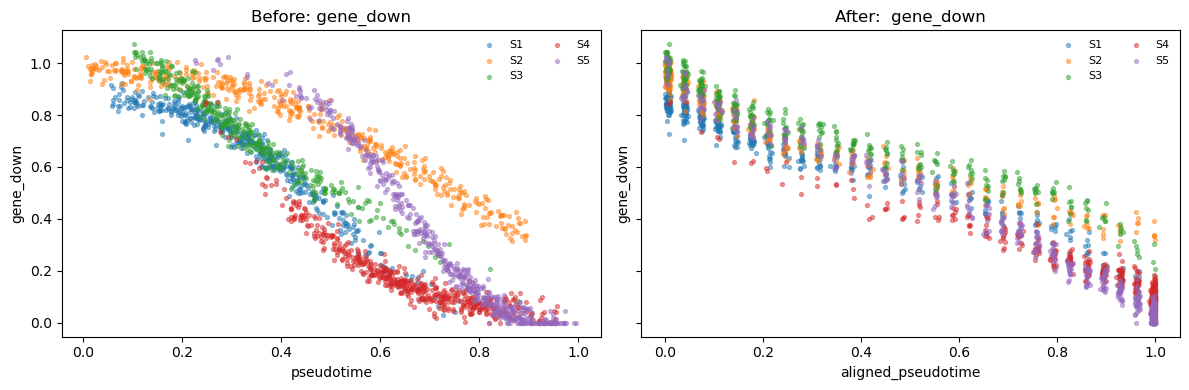

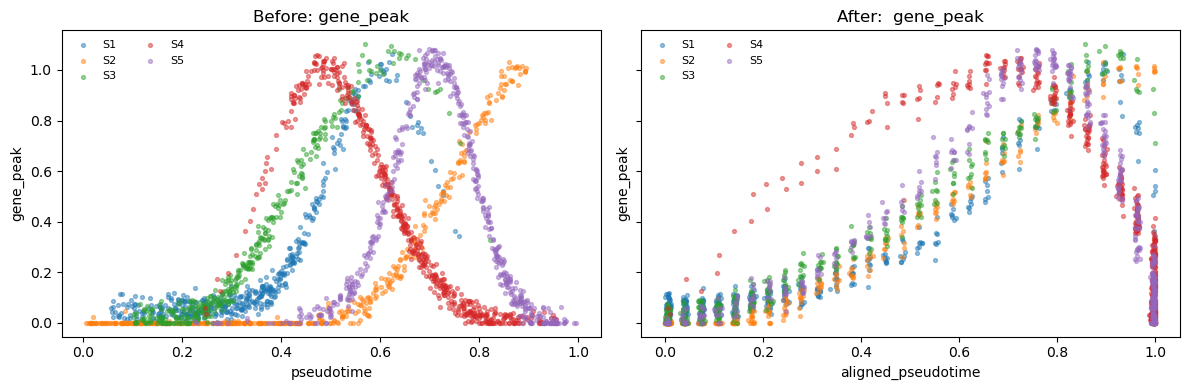

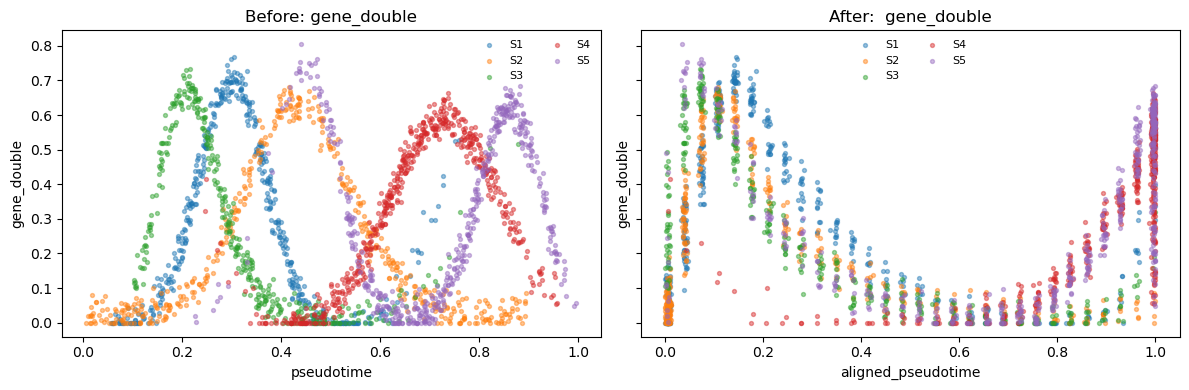

In [ ]:
def plot_gene_dots(adata, gene, field="pseudotime", ax=None, s=8, alpha=0.45, jitter=None, seed=0):
    """Scatter the raw (non-smoothed) points for `gene` using x = adata.obs[field]."""
    if ax is None:
        ax = plt.gca()
    rng = np.random.default_rng(seed)
    for sid in adata.obs["sample"].unique():
        m = (adata.obs["sample"] == sid).values
        x = adata.obs.loc[m, field].values.astype(float)
        y = adata[:, gene].X[m]
        y = y.A1 if hasattr(y, "A1") else y.flatten()
        if jitter:
            x = np.clip(x + rng.normal(0, jitter, size=x.size), 0, 1)
        ax.scatter(x, y, s=s, alpha=alpha, label=str(sid), rasterized=True)
    ax.set_xlabel(field)
    ax.set_ylabel(gene)
    ax.legend(fontsize=8, ncols=2, frameon=False)
    return ax


genes = adata.var_names[:4]
for g in genes:
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    plot_gene_dots(adata, g, field="pseudotime", ax=axs[0], s=8, alpha=0.45, jitter=0.003)
    axs[0].set_title(f"Before: {g}")
    plot_gene_dots(adata, g, field="aligned_pseudotime", ax=axs[1], s=8, alpha=0.45, jitter=0.003)
    axs[1].set_title(f"After:  {g}")
    plt.tight_layout()
    plt.show()